<a href="https://colab.research.google.com/github/LC1332/Zero-Haruhi/blob/main/notebook/%E6%B5%8B%E8%AF%95FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [ ] 导入视频
- [ ] 选一个时间
- [ ] 看看detection能不能跑

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/SD/exp0226

expression_example.mp4


In [3]:
input_video = "/content/drive/MyDrive/SD/exp0226/expression_example.mp4"
target_folder = "/content/"

import shutil

shutil.copy(input_video, target_folder)

'/content/expression_example.mp4'

In [4]:
%cd /content
!rm -rf /content/smooth-face-extract
!git clone https://github.com/LC1332/smooth-face-extract


/content
Cloning into 'smooth-face-extract'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 28), reused 3 (delta 1), pack-reused 0
Receiving objects: 100% (56/56), 27.63 KiB | 6.91 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [5]:
%cd /content/smooth-face-extract/Face_detection_src
!ls
!mkdir face_images

/content/smooth-face-extract/Face_detection_src
combine_img_to_video.py        FaceDetection_MAFilter.py  __init__
FaceDetection_KalmanFilter.py  FaceDetection.py


In [6]:
!pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 28.3 MB/s eta 0:00:00


In [7]:
!rm -rf face_images

!rm -rf output

In [8]:

!python FaceDetection_KalmanFilter.py --input_video_name /content/expression_example.mp4 \
    --start_time 00:43:55 \
    --end_time 00:44:04 \
    --maxcenter_speed 30


2024-02-29 11:01:53.299847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 11:01:53.299913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 11:01:53.301373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 11:01:53.310062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 11:01:54.881161: W tensorflow/compiler/tf2

---

# 重写实验

这里实验效果没有达到预期，我们直接进行重写

计划是这样的

- [ ] 整个video读入后，变成list of center_x, center_y, half_win_size
- [ ] 进行可视化和滤波实验
- [ ] 然后再切一次

In [12]:
input_video_name = "/content/expression_example.mp4"
start_time = "00:43:55"
end_time = "00:44:04"


In [13]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

In [96]:
def get_frame_no(time_str, fps):
    h, m, s = map(int, time_str.split(":"))
    return int((h * 3600 + m * 60 + s) * fps)

import cv2

import mediapipe as mp


def get_face_detector():

    mp_face_detection = mp.solutions.face_detection
    return mp_face_detection.FaceDetection(min_detection_confidence=0.8)

    ## TODO 也可以换成video

    # BaseOptions = mp.tasks.BaseOptions
    # FaceDetector = mp.tasks.vision.FaceDetector
    # FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
    # VisionRunningMode = mp.tasks.vision.RunningMode

    # # Create a face detector instance with the video mode:
    # options = FaceDetectorOptions(
    #     base_options= BaseOptions( model_asset_path='detector.tflite'),
    #     running_mode=VisionRunningMode.VIDEO,
    #     min_detection_confidence=0.5)

    # face_detector = FaceDetector.create_from_options(options)
    # return face_detector


def video_to_boxes( video_name, start_time, end_time ):
    ans = []
    cap = cv2.VideoCapture(video_name)
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame_no = get_frame_no(start_time, fps)
    end_frame_no = get_frame_no(end_time, fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_no)
    ret, frame = cap.read()

    face_detector = get_face_detector()

    while cap.isOpened():
        success, image = cap.read()
        frame_id = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if not success or frame_id > end_frame_no:
            break
        results = face_detector.process(image)
        ans.append(results)

    cap.release()

    return ans

def get_video_shape( video_name ):
    cap = cv2.VideoCapture(video_name)

    ret, frame = cap.read()

    video_shape = frame.shape

    return video_shape[0], video_shape[1]



video_height, video_width = get_video_shape(input_video_name)


detection_results = video_to_boxes(input_video_name, start_time, end_time)

In [97]:
print(video_height)

720


In [98]:
count = 0
for i, frame_result in enumerate(detection_results):
    if frame_result.detections:
        count += len(frame_result.detections)

print(count)

50


找到全序列最大的人脸

In [99]:
def get_max_face_index(detection_results):
    maximal_area = -1
    max_frame_index = -1
    max_result = None
    for i, frame_result in enumerate(detection_results):
        if frame_result.detections:
            for result in frame_result.detections:
                area = result.location_data.relative_bounding_box.width * result.location_data.relative_bounding_box.height
                if area > maximal_area:
                    maximal_area = area
                    max_frame_index = i
                    max_result = result
    return max_frame_index, max_result

max_frame_index, max_result = get_max_face_index(detection_results)
print(max_result)


label_id: 0
score: 0.5661634802818298
location_data {
  format: RELATIVE_BOUNDING_BOX
  relative_bounding_box {
    xmin: 0.5057213306427002
    ymin: 0.11977088451385498
    width: 0.3297649621963501
    height: 0.5861427187919617
  }
  relative_keypoints {
    x: 0.600339949131012
    y: 0.5042380094528198
  }
  relative_keypoints {
    x: 0.6772907972335815
    y: 0.2867819666862488
  }
  relative_keypoints {
    x: 0.744242787361145
    y: 0.496986985206604
  }
  relative_keypoints {
    x: 0.7983250021934509
    y: 0.5480449199676514
  }
  relative_keypoints {
    x: 0.533044159412384
    y: 0.6292794346809387
  }
  relative_keypoints {
    x: 0.6996224522590637
    y: 0.16362953186035156
  }
}



In [100]:
def get_winsize( data , video_height, video_width ):
    # return relative winsize to the height
    ans = data.location_data.relative_bounding_box.width
    ans += (data.location_data.relative_bounding_box.height * video_height / video_width)
    return ans / 2

从前向后和从后向前选取track的人脸

In [101]:
def get_center_x( data ):
    return data.location_data.relative_bounding_box.xmin + data.location_data.relative_bounding_box.width/2

def get_center_y( data ):
    return data.location_data.relative_bounding_box.ymin + data.location_data.relative_bounding_box.height/2


def grab_one_face_from_detection( detection_results, max_frame_index, max_result ):
    n_frame = len(detection_results)
    maximal_location = max_result.location_data.relative_bounding_box

    last_result = max_result
    center_x = maximal_location.xmin + maximal_location.width / 2
    center_y = maximal_location.ymin + maximal_location.height / 2

    post_ans = []

    # 从前向后选取track的人脸
    for i in range( max_frame_index, n_frame ):
        if detection_results[i].detections:
            nearest_box = min( detection_results[i].detections, \
                              key=lambda x: abs( get_center_x(x) - get_center_x(last_result) ) \
                               + abs(get_center_y(x)  - get_center_y(last_result)) )
            post_ans.append( nearest_box )
            last_result = nearest_box
        else:
            post_ans.append( last_result )

    pre_ans = []

    last_result = max_result
    center_x = maximal_location.xmin + maximal_location.width / 2
    center_y = maximal_location.ymin + maximal_location.height / 2

    for i in range( max_frame_index-1, 0-1, -1 ):
        if detection_results[i].detections:
            nearest_box = min( detection_results[i].detections, \
                               key=lambda x: abs( get_center_x(x) - get_center_x(last_result) ) \
                               + abs(get_center_y(x)  - get_center_y(last_result)) )
            pre_ans.append( nearest_box )
            last_result = nearest_box
        else:
            pre_ans.append( last_result )

    ans = pre_ans[::-1] + post_ans

    return ans


box_per_frame = grab_one_face_from_detection(detection_results, max_frame_index, max_result)

In [102]:
print(get_winsize(box_per_frame[0], video_height, video_width))

0.1415957510471344


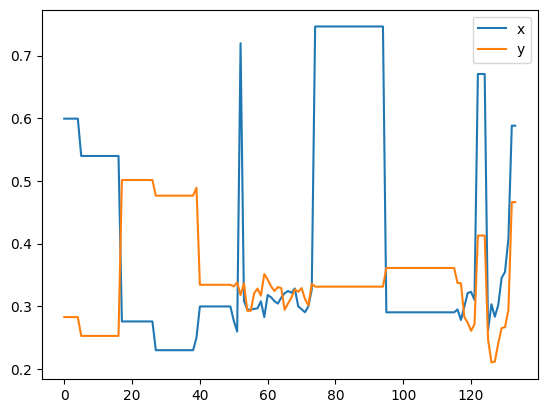

In [103]:
import matplotlib.pyplot as plt
ns = [i for i in range(len(box_per_frame))]
xs = [get_center_x(box) for box in box_per_frame]
ys = [get_center_y(box) for box in box_per_frame]
plt.plot(ns, xs, label="x")
plt.plot(ns, ys, label="y")
plt.legend()
plt.show()

这里一般的方法太复杂了，我们直接使用手写规则的方法

In [104]:
max_velocity = 15

def normalize_position( x, y , half_win_size , video_height, video_width ):
    half_win_size = min( 0.5, half_win_size )
    # y - half_win_size > 0
    y = max( y, half_win_size)
    # y + half_win_size < 1
    y = min( y, 1 - half_win_size )

    half_win_size_for_x = half_win_size * video_height / video_width
    # x - half_win_size_for_x > 0
    x = max( x, half_win_size_for_x )
    # x + half_win_size_for_x < 1
    x = min( x, 1 - half_win_size_for_x )

    return x, y, half_win_size


def filter_box( box_per_frame, video_height, video_width ):

    max_velocity_in_x = max_velocity / video_width
    max_velocity_in_y = max_velocity / video_height

    datas = []
    for box in box_per_frame:
        datas.append({
            "x": get_center_x(box),
            "y": get_center_y(box),
            "half_win_size": get_winsize(box, video_height, video_width)/2.0
        })

    ans = [datas[0]]
    last_data = datas[0]

    for data in datas[1:]:
        x = data["x"]
        y = data["y"]
        half_win_size = data["half_win_size"]
        # last_x - max_velocity_in_x < x < last_x + max_velocity_in_x

        new_x = max( last_data["x"] - max_velocity_in_x, min( last_data["x"] + max_velocity_in_x, x ) )
        new_y = max( last_data["y"] - max_velocity_in_y, min( last_data["y"] + max_velocity_in_y, y ) )

        new_half_win_size = half_win_size + max( abs(new_x - x) , abs(new_y - y) )

        last_hws = last_data["half_win_size"]
        #last_hws-max_velocity_in_y  <  new_half_win_size < last_hws+max_velocity_in_y
        new_half_win_size = max( last_hws - 3*max_velocity_in_y, min( last_hws + 3*max_velocity_in_y, new_half_win_size ) )

        new_x, new_y, new_half_win_size = normalize_position( new_x, new_y, new_half_win_size, video_height, video_width )

        ans.append({
            "x": new_x,
            "y": new_y,
            "half_win_size": new_half_win_size
        })
        last_data = ans[-1]

    return ans

filtered_box = filter_box(box_per_frame, video_height, video_width)

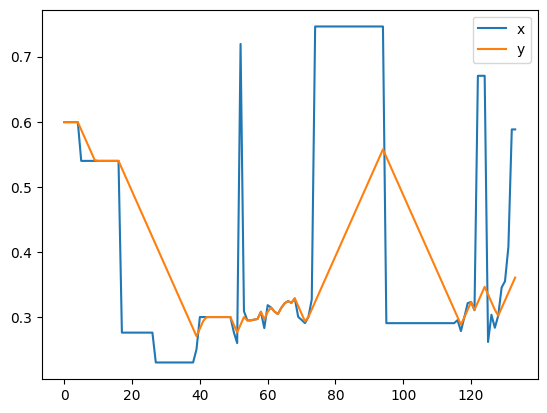

In [105]:
import matplotlib.pyplot as plt
ns = [i for i in range(len(box_per_frame))]
xs = [get_center_x(box) for box in box_per_frame]
fxs = [box["x"] for box in filtered_box]
plt.plot(ns, xs, label="x")
plt.plot(ns, fxs, label="y")
plt.legend()
plt.show()

# 这里的x和y随时间也可以再MA平滑一下

In [106]:
def crop_video( video_name,  start_time, end_time, filtered_box ):
    ans = []
    cap = cv2.VideoCapture(video_name)
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame_no = get_frame_no(start_time, fps)
    end_frame_no = get_frame_no(end_time, fps)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_no)
    ret, frame = cap.read()

    face_detector = get_face_detector()

    index = 0

    cropped_face_out = None

    while cap.isOpened():
        success, image = cap.read()
        frame_id = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if not success or frame_id > end_frame_no:
            break
        if index > len(filtered_box) - 1:
            break

        if cropped_face_out is None:
          cropped_face_out = cv2.VideoWriter('output/cropped_face.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (640, 640))

        box = filtered_box[index]
        index += 1
        x = box["x"]
        y = box["y"]
        half_win_size_int = int( image.shape[0] * box["half_win_size"] )

        start_x = int( image.shape[1] * x ) - half_win_size_int
        start_y = int( image.shape[0] * y ) - half_win_size_int
        end_x = int( image.shape[1] * x ) + half_win_size_int
        end_y = int( image.shape[0] * y ) + half_win_size_int
        face = image[max(start_y, 0):min(end_y, image.shape[0]), max(start_x, 0):min(end_x, image.shape[1])]

        face = cv2.resize(face, (640, 640))
        cropped_face_out.write(face)


    cap.release()

    return ans

crop_video = crop_video(input_video_name, start_time, end_time, filtered_box)